# Text classification with Reuters-21578 datasets
Downloaded the from reuters21578 data set first. https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/

* Tested with Python 3.5
* Keras with Tensorflow 1.3 backend

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\NII\AppData\Local\conda\conda\envs\keras\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'place']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
import re
import xml.sax.saxutils as saxutils

from bs4 import BeautifulSoup

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from pandas import DataFrame

from random import random
import numpy as np
# Set Numpy random seed
np.random.seed(1)

## General constants (modify them according to you environment)

In [25]:

# TODO: download the dataset and change the data_folder to match with yours
# Downloaded from https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/
data_folder = 'D:\\Learning\\zoomtail\\reuters21578\\'

sgml_number_of_files = 22
sgml_file_name_template = 'reut2-{}.sgm'

# Category files
category_files = {
    'to_': ('Topics', 'all-topics-strings.lc.txt'),
    'pl_': ('Places', 'all-places-strings.lc.txt'),
    'pe_': ('People', 'all-people-strings.lc.txt'),
    'or_': ('Organizations', 'all-orgs-strings.lc.txt'),
    'ex_': ('Exchanges', 'all-exchanges-strings.lc.txt')
}

## Prepare documents and categories

In [26]:
# Read all categories
category_data = []

for category_prefix in category_files.keys():
    with open(data_folder + category_files[category_prefix][1], 'r') as file:
        for category in file.readlines():
            category_data.append([category_prefix + category.strip().lower(), 
                                  category_files[category_prefix][0], 
                                  0])

# Create category dataframe
news_categories = DataFrame(data=category_data, columns=['Name', 'Type', 'Newslines'])

In [27]:
def update_frequencies(categories):
    for category in categories:
        idx = news_categories[news_categories.Name == category].index[0]
        f = news_categories.get_value(idx, 'Newslines')
        news_categories.set_value(idx, 'Newslines', f+1)
    
def to_category_vector(categories, target_categories):
    vector = zeros(len(target_categories)).astype(float32)
    
    for i in range(len(target_categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0
    
    return vector

In [28]:
# Those are the top 20 categories we will use for the classification
selected_categories = ['pl_usa', 'to_earn', 'to_acq', 'pl_uk', 'pl_japan', 'pl_canada', 'to_money-fx',
 'to_crude', 'to_grain', 'pl_west-germany', 'to_trade', 'to_interest',
 'pl_france', 'or_ec', 'pl_brazil', 'to_wheat', 'to_ship', 'pl_australia',
 'to_corn', 'pl_china']

# Parse SGML files
document_X = []
document_Y = []

def strip_tags(text):
    return re.sub('<[^<]+?>', '', text).strip()

def unescape(text):
    return saxutils.unescape(text)

# Iterate all files
for i in range(sgml_number_of_files):
    file_name = sgml_file_name_template.format(str(i).zfill(3))
    print('Reading file: %s' % file_name)
    
    with open(data_folder + file_name, 'rb') as file:
        content = BeautifulSoup(file.read().lower(), "html.parser")
        
        for newsline in content('reuters'):
            document_categories = []
            
            # News-line Id
            document_id = newsline['newid']
            
            # News-line text
            document_body = strip_tags(str(newsline('text')[0].text)).replace('reuter\n&#3;', '')
            document_body = unescape(document_body)
            
            # News-line categories
            topics = newsline.topics.contents
            places = newsline.places.contents
            people = newsline.people.contents
            orgs = newsline.orgs.contents
            exchanges = newsline.exchanges.contents
            
            for topic in topics:
                document_categories.append('to_' + strip_tags(str(topic)))
                
            for place in places:
                document_categories.append('pl_' + strip_tags(str(place)))
                
            for person in people:
                document_categories.append('pe_' + strip_tags(str(person)))
                
            for org in orgs:
                document_categories.append('or_' + strip_tags(str(org)))
                
            for exchange in exchanges:
                document_categories.append('ex_' + strip_tags(str(exchange)))
                
            # Create new document    
            update_frequencies(document_categories)
            
            document_X.append(document_body)
            document_Y.append(to_category_vector(document_categories, selected_categories))

Reading file: reut2-000.sgm


C:\Users\NII\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
C:\Users\NII\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Reading file: reut2-001.sgm
Reading file: reut2-002.sgm
Reading file: reut2-003.sgm
Reading file: reut2-004.sgm
Reading file: reut2-005.sgm
Reading file: reut2-006.sgm
Reading file: reut2-007.sgm
Reading file: reut2-008.sgm
Reading file: reut2-009.sgm
Reading file: reut2-010.sgm
Reading file: reut2-011.sgm
Reading file: reut2-012.sgm
Reading file: reut2-013.sgm
Reading file: reut2-014.sgm
Reading file: reut2-015.sgm
Reading file: reut2-016.sgm
Reading file: reut2-017.sgm
Reading file: reut2-018.sgm
Reading file: reut2-019.sgm
Reading file: reut2-020.sgm
Reading file: reut2-021.sgm


## Select top 20 categories (by number of newslines)

In [29]:
news_categories.sort_values(by='Newslines', ascending=False, inplace=True)
# Selected categories
selected_categories = np.array(news_categories["Name"].head(20))
num_categories = 20
news_categories.head(num_categories)

,Name,Type,Newslines
296,pl_usa,Places,12542
35,to_earn,Topics,3987
0,to_acq,Topics,2448
293,pl_uk,Places,1489
219,pl_japan,Places,1138
166,pl_canada,Places,1104
73,to_money-fx,Topics,801
28,to_crude,Topics,634
45,to_grain,Topics,628
302,pl_west-germany,Places,567


### Take a look at the input and output data
The output data **document_Y** looks good, it is a list of 20 (1 or 0) representing 20 categories.

The input data still need to be cleaned up for the model input.

In [30]:
print(document_X[220])
print(document_Y[220])


average yen cd rates fall in latest week
    tokyo, feb 27 - average interest rates on yen certificates
of deposit, cd, fell to 4.27 pct in the week ended february 25
from 4.32 pct the previous week, the bank of japan said.
    new rates (previous in brackets), were -
    average cd rates all banks 4.27 pct (4.32)
    money market certificate, mmc, ceiling rates for the week
starting from march 2          3.52 pct (3.57)
    average cd rates of city, trust and long-term banks
    less than 60 days          4.33 pct (4.32)
    60-90 days                 4.13 pct (4.37)
    average cd rates of city, trust and long-term banks
    90-120 days             4.35 pct (4.30)
    120-150 days            4.38 pct (4.29)
    150-180 days            unquoted (unquoted)
    180-270 days            3.67 pct (unquoted)
    over 270 days           4.01 pct (unquoted)
    average yen bankers' acceptance rates of city, trust and
long-term banks
    30 to less than 60 days unquoted (4.13)
    60-90 days

## Clean up the data
Function to clean up data
* Only take characters inside A-Za-z0-9
* remove stop words
* lemmatize

In [31]:
lemmatizer = WordNetLemmatizer()
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
stop_words = set(stopwords.words("english"))

def cleanUpSentence(r, stop_words = None):
    r = r.lower().replace("<br />", " ")
    r = re.sub(strip_special_chars, "", r.lower())
    if stop_words is not None:
        words = word_tokenize(r)
        filtered_sentence = []
        for w in words:
            w = lemmatizer.lemmatize(w)
            if w not in stop_words:
                filtered_sentence.append(w)
        return " ".join(filtered_sentence)
    else:
        return r

### Here we are cleaning up the data

In [32]:
totalX = []
totalY = np.array(document_Y)
for i, doc in enumerate(document_X):
    totalX.append(cleanUpSentence(doc, stop_words))

### Take a look at the input and output data now
The input data looks clean and ready to be turned to ids

In [33]:
print(totalX[220])
print(totalY[220])

average yen cd rate fall latest week tokyo feb 27 average interest rate yen certificatesof deposit cd fell 427 pct week ended february 25from 432 pct previous week bank japan said new rate previous bracket average cd rate bank 427 pct 432 money market certificate mmc ceiling rate weekstarting march 2 352 pct 357 average cd rate city trust longterm bank le 60 day 433 pct 432 6090 day 413 pct 437 average cd rate city trust longterm bank 90120 day 435 pct 430 120150 day 438 pct 429 150180 day unquoted unquoted 180270 day 367 pct unquoted 270 day 401 pct unquoted average yen banker acceptance rate city trust andlongterm bank 30 le 60 day unquoted 413 6090 day unquoted unquoted 90120 day unquoted unquoted reuter
[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Show input max sequence length
If the max input sequence length is too long, we can put a limit to it in order to reduce the training time.

In [34]:
xLengths = [len(word_tokenize(x)) for x in totalX]
h = sorted(xLengths)  #sorted lengths
maxLength =h[len(h)-1]
print("max input length is: ",maxLength)

max input length is:  1500


### Choose a smaller max length for input sequence to reduce the training time

In [35]:
maxLength = h[int(len(h) * 0.70)]
print("70% cover input sequence length up to",maxLength)

70% cover input sequence length up to 88


## Convert input words to ids
**max_vocab_size**: the maximum number of words to keep, we choose 30000 since it is big enough to keep all words in this case.

Pad each input sequence to max input length **maxLength** if it is shorter.

In [36]:
max_vocab_size = 200000
input_tokenizer = Tokenizer(max_vocab_size)
input_tokenizer.fit_on_texts(totalX)
input_vocab_size = len(input_tokenizer.word_index) + 1
print("input_vocab_size:",input_vocab_size)
totalX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(totalX), maxlen=maxLength))

input_vocab_size: 167135


In [66]:
import _pickle as cPickle
with open(r"input_tokenizer.pickle", "wb") as output_file:
    cPickle.dump(input_tokenizer, output_file)

## Create Keras model

* Embedding layer embed a sequence of vectors of size 256
* GRU layers(recurrent network) which process the sequence data
* Dense layer output the classification result of 20 categories

In [45]:
embedding_dim = 256
model = Sequential()
model.add(Embedding(input_vocab_size, embedding_dim,input_length = maxLength))
model.add(GRU(256, dropout=0.9, return_sequences=True))
model.add(GRU(256, dropout=0.9))
model.add(Dense(num_categories, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train model

In [46]:
history = model.fit(totalX, totalY, validation_split=0.1, batch_size=128, epochs=10)

Train on 19420 samples, validate on 2158 samples
Epoch 1/10
19420/19420 [==============================] - 730s 38ms/step - loss: 0.2181 - acc: 0.9267 - val_loss: 0.1517 - val_acc: 0.9492
Epoch 2/10
19420/19420 [==============================] - 712s 37ms/step - loss: 0.1597 - acc: 0.9502 - val_loss: 0.1093 - val_acc: 0.9658
Epoch 3/10
19420/19420 [==============================] - 710s 37ms/step - loss: 0.1365 - acc: 0.9586 - val_loss: 0.1061 - val_acc: 0.9673
Epoch 4/10
19420/19420 [==============================] - 709s 36ms/step - loss: 0.1286 - acc: 0.9601 - val_loss: 0.1035 - val_acc: 0.9678
Epoch 5/10
19420/19420 [==============================] - 707s 36ms/step - loss: 0.1213 - acc: 0.9611 - val_loss: 0.1011 - val_acc: 0.9684
Epoch 6/10
19420/19420 [==============================] - 708s 36ms/step - loss: 0.1139 - acc: 0.9625 - val_loss: 0.0991 - val_acc: 0.9683
Epoch 7/10
19420/19420 [==============================] - 708s 36ms/step - loss: 0.1077 - acc: 0.9642 - val_loss: 0.0

In [49]:
model.save("classification_model.h5")

## Visualize the training performance

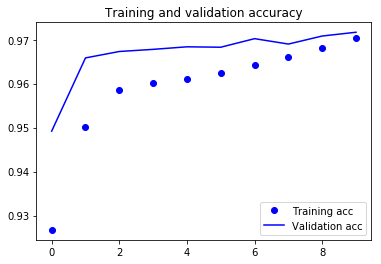

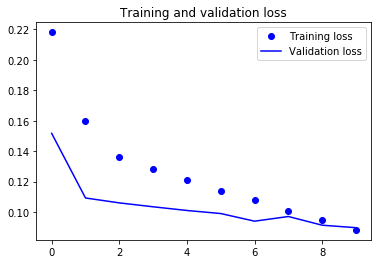

In [50]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Lets predict from one of our news data
Here is the raw text from news at index 220

In [51]:
doc220 = document_X[220]
print(doc220)


average yen cd rates fall in latest week
    tokyo, feb 27 - average interest rates on yen certificates
of deposit, cd, fell to 4.27 pct in the week ended february 25
from 4.32 pct the previous week, the bank of japan said.
    new rates (previous in brackets), were -
    average cd rates all banks 4.27 pct (4.32)
    money market certificate, mmc, ceiling rates for the week
starting from march 2          3.52 pct (3.57)
    average cd rates of city, trust and long-term banks
    less than 60 days          4.33 pct (4.32)
    60-90 days                 4.13 pct (4.37)
    average cd rates of city, trust and long-term banks
    90-120 days             4.35 pct (4.30)
    120-150 days            4.38 pct (4.29)
    150-180 days            unquoted (unquoted)
    180-270 days            3.67 pct (unquoted)
    over 270 days           4.01 pct (unquoted)
    average yen bankers' acceptance rates of city, trust and
long-term banks
    30 to less than 60 days unquoted (4.13)
    60-90 days

### First clean up the input data

In [52]:
input_x_220 = cleanUpSentence(doc220, stop_words)
print(input_x_220)

average yen cd rate fall latest week tokyo feb 27 average interest rate yen certificatesof deposit cd fell 427 pct week ended february 25from 432 pct previous week bank japan said new rate previous bracket average cd rate bank 427 pct 432 money market certificate mmc ceiling rate weekstarting march 2 352 pct 357 average cd rate city trust longterm bank le 60 day 433 pct 432 6090 day 413 pct 437 average cd rate city trust longterm bank 90120 day 435 pct 430 120150 day 438 pct 429 150180 day unquoted unquoted 180270 day 367 pct unquoted 270 day 401 pct unquoted average yen banker acceptance rate city trust andlongterm bank 30 le 60 day unquoted 413 6090 day unquoted unquoted 90120 day unquoted unquoted reuter


### Turn the text to padded ids then feed to the model

In [61]:
textArray = np.array(pad_sequences(input_tokenizer.texts_to_sequences([input_x_220]), maxlen=maxLength))
from keras.models import load_model
new_model = load_model("classification_model.h5")
predicted = new_model.predict(textArray)[0]

In [64]:
for i, prob in enumerate(predicted):
    print(prob, selected_categories[i])

0.12744065 pl_usa
0.0004817822 to_earn
0.00097138644 to_acq
0.060339585 pl_uk
0.19921212 pl_japan
0.0038564976 pl_canada
0.78513294 to_money-fx
0.0120921 to_crude
0.009678422 to_grain
0.09541289 pl_west-germany
0.0796486 to_trade
0.6132422 to_interest
0.18687144 pl_france
0.060039848 or_ec
0.059877448 pl_brazil
0.0037294093 to_wheat
0.0514342 to_ship
0.011062657 pl_australia
0.0061903964 to_corn
0.037115827 pl_china


### Lets take a look at the result

In [62]:
for i, prob in enumerate(predicted):
    if prob > 0.2:
        print(selected_categories[i])

to_money-fx
to_interest


### And here is the ground truth
Looks like the model got 2 out of 3 right for the given text

In [63]:
categories_220 = document_Y[220]
for i, prob in enumerate(categories_220):
    if prob > 0.2:
        print(selected_categories[i])

pl_japan
to_money-fx
to_interest
